In [1]:
cp -r /data/p303146/s21cm_Astro-3.zarr* /local/tmp

In [1]:
import numpy as np
import scipy
import pickle

import torch
import swyft.lightning as sl

import seaborn as sns
sns.set_theme(style="whitegrid", font="STIXgeneral")

import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "stix"
%config InlineBackend.figure_format = "svg"
%matplotlib inline

In [2]:
# Redshifts
reds = [10.714930, 9.402521, 8.237142, 7.202319, 6.429094]

# Parameters: zeta, Tvir, Rmfp, Lx, E0, \alpha
labels = [r'$\zeta$', r'$T_{\rm vir}^{\rm min}$', r'$R_{\rm mfp}$']

# True values of the parameters
vtrue = np.array([30, 4.69897, 15])

# Priors
vmin = np.array([10, 4.2, 8])
vmax = np.array([100, 5.4, 25])

# Path for mock observation and noise
noisePath = "./ska_low_noise.npy"
obsPath = "./mockObs.pkl"

In [3]:
!cp /home/p303146/Projects/Inference21cm/Astro_6/fixSeed/swyft/ska_low_noise.npy .

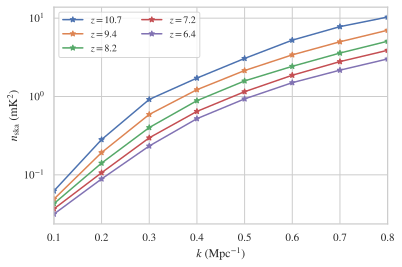

In [4]:
# Instrumental noise level from SKA low: sim using ps_eor
instNoise = np.load(noisePath)
k_vals = np.linspace(0.1, 0.8, 8)
fig, ax = plt.subplots()
for i in range(len(reds)):
    ax.plot(k_vals, instNoise[5+i], "*-", label=r"$z = %.1f$"%reds[i])
    ax.set_yscale("log")
    ax.set_xlim(k_vals[0], k_vals[-1])
    ax.legend(ncol=2, fontsize=10)
    ax.set_xlabel(r"$k$ (Mpc$^{-1})$")
    ax.set_ylabel(r"$n_{\rm ska}$ (mK$^2$)")

In [5]:
instNoise[5:]

array([[ 0.06222046,  0.2816813 ,  0.9175757 ,  1.7180775 ,  3.0602176 ,
         5.2375937 ,  7.791815  , 10.332077  ],
       [ 0.04893309,  0.19222248,  0.5900396 ,  1.2212687 ,  2.143758  ,
         3.3995302 ,  4.994353  ,  7.0098248 ],
       [ 0.04285526,  0.14108633,  0.40127957,  0.88453877,  1.5808077 ,
         2.4266555 ,  3.5847874 ,  5.076254  ],
       [ 0.03673099,  0.10631779,  0.2968151 ,  0.6452443 ,  1.1514293 ,
         1.867034  ,  2.7880726 ,  3.887712  ],
       [ 0.03152769,  0.08863583,  0.23334602,  0.52095705,  0.93167424,
         1.5006379 ,  2.1676626 ,  3.0152776 ]], dtype=float32)

In [6]:
# Use it as a hook: includes the instrumental noise and sample variance
def noise(out):
    for i in range(len(reds)):
        mu = out['pk_mu_z%.1f'%reds[i]]
        sv = out['pk_sv_z%.1f'%reds[i]]
        
        # Total noise including the intrumental noise and sample variance
        total_noise_val = np.sqrt(instNoise[5+i]**2. + sv**2.)
        n = np.float32(np.random.randn(*total_noise_val.shape))*total_noise_val
        
        out['pk_z%.1f'%reds[i]] = mu + n
    return out

In [7]:
zs = sl.ZarrStore("/local/tmp/s21cm_Astro-3.zarr")
data_loader_train = zs.get_dataloader(num_workers=12, batch_size=128, idx_range=[0, 18_500], hook=noise)
data_loader_val = zs.get_dataloader(num_workers=12, batch_size=128, idx_range=[18_500, 23_000], hook=noise)

In [8]:
zarrSamples = zs.get_sample_store()

In [9]:
len(zarrSamples)

30000

In [10]:
trainer_1D = sl.SwyftTrainer(accelerator='gpu', gpus=1, max_epochs=100,
                             **sl.tensorboard_config(save_dir="./lightning_logs", name='post1D', version=None))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [11]:
class Network_1D(sl.SwyftModule):
    def __init__(self):
        super().__init__(lr=1e-4)
        
        self.n_features = 16
        self.l = torch.nn.Linear(40, 16)
        self.classifier = sl.RatioEstimatorMLP1d(self.n_features, len(vtrue), hidden_features=256,
                                                 num_blocks=2, dropout=0.1)       
        
    def forward(self, A, B):
        x = torch.cat([A['pk_z%.1f'%zi] for zi in reds], axis=1)
        x = self.l(x)
        z = B['z']
        ratios_z = self.classifier(x, z)
        return dict(z = ratios_z)

In [12]:
network_1D = Network_1D()

In [13]:
%%time
trainer_1D.fit(network_1D, data_loader_train, data_loader_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name       | Type                | Params
---------------------------------------------------
0 | l          | Linear              | 656   
1 | classifier | RatioEstimatorMLP1d | 810 K 
---------------------------------------------------
810 K     Trainable params
0         Non-trainable params
810 K     Total params
3.244     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/data/p303146/.envs/lightning/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 36.9 s, sys: 19.6 s, total: 56.5 s
Wall time: 1min 9s


In [14]:
noise(zarrSamples[0])

{'meanTb': array([25.60022 , 20.34853 , 13.54989 ,  5.942725,  1.59383 ],
       dtype=float32),
 'pk_mu_z10.7': array([ 2.0896146,  8.117842 , 15.308703 , 20.832071 , 25.852774 ,
        30.53348  , 34.08652  , 36.77657  ], dtype=float32),
 'pk_mu_z6.4': array([9.330093 , 5.732711 , 4.4254885, 3.9469202, 3.536877 , 3.2991672,
        3.1685634, 3.1142097], dtype=float32),
 'pk_mu_z7.2': array([25.209723, 16.55441 , 15.538774, 13.633392, 12.556433, 12.139297,
        11.976115, 11.960353], dtype=float32),
 'pk_mu_z8.2': array([20.654198, 24.64827 , 26.576065, 25.860842, 25.323326, 25.283506,
        25.511097, 25.97139 ], dtype=float32),
 'pk_mu_z9.4': array([ 7.1843185, 15.835836 , 22.691843 , 26.4984   , 29.529524 ,
        31.514668 , 33.102375 , 34.630383 ], dtype=float32),
 'pk_sv_z10.7': array([0.19251356, 0.2581663 , 0.27188075, 0.23885329, 0.21449003,
        0.19294827, 0.17086422, 0.15105616], dtype=float32),
 'pk_sv_z6.4': array([0.8595694 , 0.18231364, 0.07859618, 0.0452540

In [31]:
# If you want to make predictions for a noiseless observation, then use 'pk_mu_z' key instead.
pd_1D = trainer_1D.infer(network_1D, data_loader_train,
                         conditions={'pk_z%.1f'%zi: 
                                     torch.tensor(noise(zarrSamples[6389])['pk_z%.1f'%zi], 
                                                 dtype=torch.float32) for zi in reds})

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 145it [00:00, ?it/s]

In [32]:
post_samples_1D = pd_1D.sample(1_000_000)
samples_1D = post_samples_1D['z'].numpy()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
cn = 0
for j in range(3):
    sns.kdeplot(ax=axes[j], data=samples_1D[:, cn], color="r", bw_adjust=2, fill=True)
    axes[j].axvline(zarrSamples[6389]['z'][cn], color='k')
    axes[j].set_xlabel("%s"%labels[cn])
    axes[j].set_ylabel("")
    cn += 1
plt.tight_layout()
plt.savefig("post1D_3params.pdf", bbox_inches="tight")
plt.show()

(0.0, 83.72790565490723)

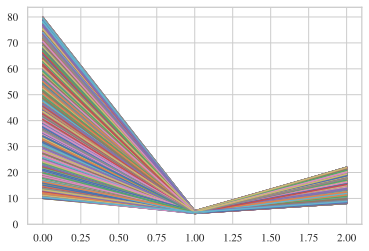

In [49]:
for i in range(4500):
    plt.plot(zarrSamples[18500+i]['z'])
plt.ylim(0,)

In [14]:
zarrSamples[23152]['z']

array([74.507805 ,  4.8320627, 19.363995 ], dtype=float32)

In [57]:
23153*0.8

18522.4

In [30]:
zarrSamples[6389]['z']

array([30.17239 ,  4.536077, 14.989246], dtype=float32)

In [27]:
dist = np.zeros(10000)
for i in range(10000):
    dist[i] = (30-zarrSamples[i]['z'][0])**2. + (4.69-zarrSamples[i]['z'][1])**2. + (15-zarrSamples[i]['z'][2])**2.

In [28]:
min(dist)

0.05352623020735676

In [29]:
np.where(dist==min(dist))

(array([6389]),)

In [34]:
mcmc_samples = np.loadtxt("/data/p303146/MCMC_3params/21CMMC_SourceCode/Programs/ReionModel_LF_taue_ska_low_Co-eval_multiz.out")

In [40]:
mcmc_samples_formatted = mcmc_samples.copy()
mcmc_samples_formatted[:, 1] = mcmc_samples[:, 2]
mcmc_samples_formatted[:, 2] = mcmc_samples[:, 1]

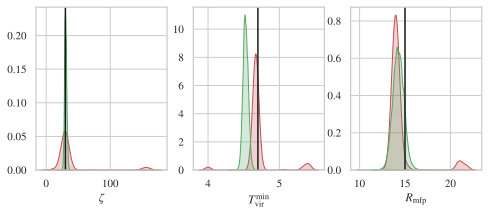

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
cn = 0
for j in range(3):
    sns.kdeplot(ax=axes[j], data=mcmc_samples_formatted[:, cn], color="r", bw_adjust=2, fill=True)
    sns.kdeplot(ax=axes[j], data=samples_1D[:, cn], color="g", bw_adjust=2, fill=True)
    axes[j].axvline(vtrue[cn], color='k')
    axes[j].set_xlabel("%s"%labels[cn])
    axes[j].set_ylabel("")
    cn+=1